In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

import copy

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

def printf(string, terminal = False):
    # function for printing stuff that gets removed from the output each iteration
    import sys
    if terminal:
        sys.stdout.write("\r")
        sys.stdout.write(string)
        sys.stdout.flush()
    else:
        from IPython.display import display, clear_output
        clear_output(wait = True)
        print(string, end = '')
        sys.stdout.flush()

# Overfitting Attempt

The purpose of this section is to see if we can make the binomial unit overfit to the fake data.

The data should be relatively easy to classify

Apologies for the messy code, this was put together in about 10 minutes :)

## Data

In [2]:
X, y = make_classification(n_samples = 10000, n_features=100, n_informative=90, n_redundant=10)

# data leakage - but the data is fake anyway so who cares?
X = torch.tensor(X)
y = torch.tensor(y)

mean = X.mean(dim = 0)
sd = X.std(dim = 0)

X = (X - mean) / sd

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# X_train, X_test, y_train, y_test = torch.tensor(X_train), torch.tensor(X_test), torch.tensor(y_train), torch.tensor(y_test)

# mean = X_train.mean(dim = 0)
# sd = X_train.std(dim = 0)

# X_train, X_test = (X_train - mean) / sd, (X_test / mean) / sd

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

## What the data looks like

Text(0.5, 1.0, 'PCA representation of the fake data')

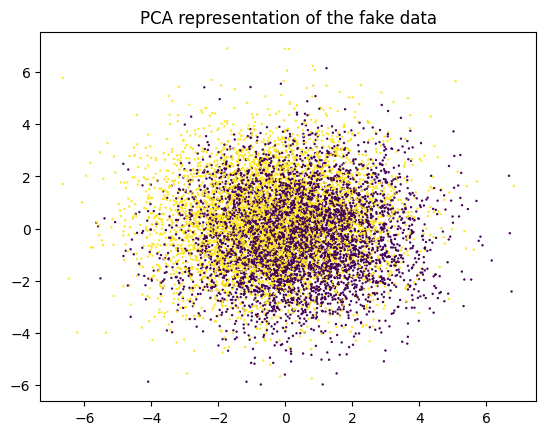

In [3]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y, s=0.5)
plt.title('PCA representation of the fake data')

## Classic NN

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 20)
        self.fc2 = nn.Linear(20, 2)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        # x = self.activation(x)
        # x = self.fc2(x)
        return self.activation(x)

criterion = nn.CrossEntropyLoss()
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Training

In [5]:
def test(test_model):
    # tests the classic NN model
    with torch.no_grad():
        model.eval()
        
        n_correct, n_total = 0,0 
        
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            
            outputs = test_model(features.float()).argmax(dim = -1)
            
            n_correct += (outputs == labels).sum().item()
            n_total += len(labels)
            
        return n_correct / n_total
        

losses = []
test_losses = []
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    n_correct, n_total = 0,0
    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)
        
        output = model(features.float())
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        n_correct += (labels == output.argmax(dim = -1)).sum().item()
        n_total += len(labels)
        
        
    epoch_loss /= len(train_loader)
    losses.append(1 - n_correct / n_total)
    test_losses.append(1 - test(model))
    print(f'Epoch: [{i+1}/{n_epochs}], Loss: {1 - n_correct / n_total}')

## Plot

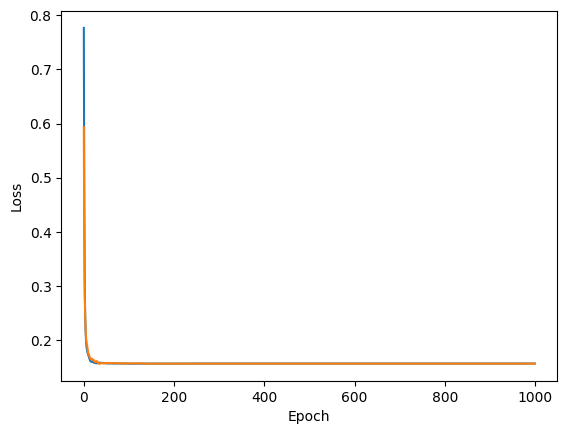

In [6]:
plt.plot(torch.arange(n_epochs), losses)
plt.plot(torch.arange(n_epochs), test_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss');

## Binomial NN

#### Gradient Approximators

In [7]:
# Surrogate gradient implementation from https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial1.ipynb
class SurrogateGradientSpike(torch.autograd.Function):
    '''takes in [-inf, inf] values'''
    scale = 100.0
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrogateGradientSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# Sigmoid Bernoulli Spikes Generation
# Implementation from https://github.com/NECOTIS/Parallelizable-Leaky-Integrate-and-Fire-Neuron/blob/main/neurons/paralif.py
class StochasticStraightThrough(torch.autograd.Function):
    '''takes in [0, 1] values'''
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.bernoulli(input)
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        return grad_input*input

# Implementation from https://github.com/NECOTIS/Parallelizable-Leaky-Integrate-and-Fire-Neuron/blob/main/neurons/paralif.py
class GumbelSoftmax(torch.nn.Module):
    def __init__(self, device, hard=True, tau=1.0):
        super().__init__()
        self.hard = hard
        self.tau = tau
        self.uniform = torch.distributions.Uniform(0, 1)
        self.softmax = torch.nn.Softmax(dim=0)
  
    def forward(self, logits):
        # Sample uniform noise
        unif = self.uniform.sample(logits.shape + (2,)).to(device)
        # Compute Gumbel noise from the uniform noise
        gumbels = -torch.log(-torch.log(unif))
        # Apply softmax function to the logits and Gumbel noise
        y_soft = self.softmax(torch.stack([(logits + gumbels[...,0]) / self.tau,
                                                     (-logits + gumbels[...,1]) / self.tau]))[0]
        if self.hard:
            # Use straight-through estimator
            y_hard = torch.where(y_soft > 0.5, 1.0, 0.0)
            ret = y_hard - y_soft.detach() + y_soft
        else:
            # Use reparameterization trick
            ret = y_soft
        return ret

#### Binomial Unit itself

In [8]:
class BinomialUnit(nn.Module):
    def __init__(self, in_features: int, out_features: int, spiker="gumbel", is_final_layer=False):
        super().__init__()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.bernoulli_generator = torch.bernoulli
        self.storage = torch.zeros(in_features, device=device)
        self.W = nn.Parameter(torch.empty((in_features, out_features))) # synaptic weights
        self.b = nn.Parameter(torch.empty(out_features))
        self.h = nn.Tanh()
        
        # gumbel and surrogate take in [-inf, inf]
        # ste takes in [0, 1]
        if spiker == "gumbel":
            self.generate = GumbelSoftmax(device=device)
        elif spiker == "ste":
            self.generate = StochasticStraightThrough.apply
        elif spiker == 'surrogate':
            self.generate = SurrogateGradientSpike.apply
        else:
            raise ValueError("spiker must be in ['gumbel', 'ste', 'surrogate']")
        
        self.generate_out = copy.deepcopy(self.generate)
        
        # he_normal for sigmoid or xavier for tahn
        if spiker == 'ste':
            nn.init.kaiming_normal_(self.W)
        else:
            nn.init.xavier_normal_(self.W)
        nn.init.constant_(self.b, 0.0)
        
        self.in_features = in_features
        self.out_features = out_features
        self.spiker = spiker
        self.is_final_layer = is_final_layer
        self.output_storage = torch.zeros((batch_size, out_features), device=device) if is_final_layer else None
    
    def forward(self, x, t, T=None):
        
        if self.spiker == 'ste':
            x = F.sigmoid(x)
        else:
            x = F.tanh(x)
        
        # makes x binary
        x = self.generate(x)
        
        # Accumulation
        x = x + self.storage
        self.storage = x.detach()

        # Unbiased estimator of the expectation
        x = x / (t + 1)  # Equation 3 on page 4
        
        # Membrane potential
        x = x @ self.W + self.b # Equation 4 on page 4
        
        # x here is NOT binary
        
        if self.spiker == 'ste':
            x = F.sigmoid(x)
        else:
            x = F.tanh(x)
        
        x = self.generate_out(x)
        if self.is_final_layer: #accumulate the outputs
            self.output_storage.add_(x)
            if t + 1 == T: # return the expectation at the end
                x = self.output_storage / T
                return x
        return x.detach()

    def reset_storage(self):
        self.storage = torch.zeros(self.in_features, device=device)
        if self.is_final_layer:
            self.output_storage = torch.zeros((batch_size, self.out_features), device=device)

#### Network

In [9]:
class Network(nn.Module):
    def __init__(self, in_features: int, out_features: int, spiker = "gumbel"):
        super().__init__()
        self.BU1 = BinomialUnit(in_features, 2, spiker = spiker, is_final_layer=True)
        # self.BU2 = BinomialUnit(256, 128, spiker = spiker)
        # self.BU3 = BinomialUnit(128, out_features, spiker = spiker, is_final_layer=True)
        self.spiker = spiker
        
        # gumbel and surrogate take in [-inf, inf]
        # ste takes in [0, 1]
        if spiker == "gumbel":
            self.generate = GumbelSoftmax(device=device)
        elif spiker == "ste":
            self.generate = StochasticStraightThrough.apply
        elif spiker == 'surrogate':
            self.generate = SurrogateGradientSpike.apply
        else:
            raise ValueError("spiker must be in ['gumbel', 'ste', 'surrogate']")
    
    def forward(self, x_init, T):
        if self.spiker == 'ste':
            x_init = F.sigmoid(x_init)
        else:
            x_init = F.tanh(x_init)
        x_init = self.generate(x_init)
        
        # Accumulation
        for t in range(T):
            x = self.BU1(x_init, t, T)
            # x = self.BU2(x, t)
            # x = self.BU3(x, t, T)

        return x.softmax(dim = -1)
    
    def reset_storage(self):
        for m in self.modules():
            if isinstance(m, BinomialUnit):
                m.reset_storage()

## Training

In [10]:
def train(
    n_epochs: int, 
    T: int, 
    spiker: str = "gumbel", 
    optimizer: str = 'sgd', 
    lr: float = 0.1
    ) -> tuple[Network, list]:
    
    model = Network(100, 2, spiker = spiker).to(device)
    if optimizer == 'sgd':
        optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    elif optimizer == 'adamax':
        optim = torch.optim.Adamax(model.parameters(), lr = lr)
    else:
        raise ValueError('Optimizer must be either "sgd" or "adamax"')
    criterion = nn.CrossEntropyLoss()
    
    losses = []

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for i, (features, labels) in enumerate(train_loader):
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features.float(), T)
            loss = criterion(outputs, labels)

            optim.zero_grad()
            loss.backward()
            optim.step()
            
            model.reset_storage()
            
            epoch_loss += loss.item()
            if (i+1) % 100 == 0:
                printf(f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        losses += [epoch_loss / len(train_loader)]
        
    return model, losses



## Plot

In [11]:
n_epochs = 1000
model, losses = train(n_epochs = n_epochs, T = 3, spiker = 'surrogate', lr = 0.01)

Epoch [1000/1000], Step [100/125], Loss: 0.6015

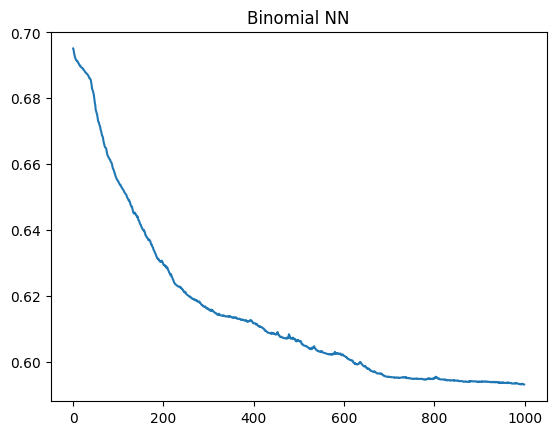

In [12]:
plt.plot(torch.arange(n_epochs), losses)
plt.title('Binomial NN'); 

In [13]:
n_epochs = 1000
model, losses = train(n_epochs = n_epochs, T = 3, spiker = 'ste', lr = 0.01)

Epoch [1000/1000], Step [100/125], Loss: 0.6931

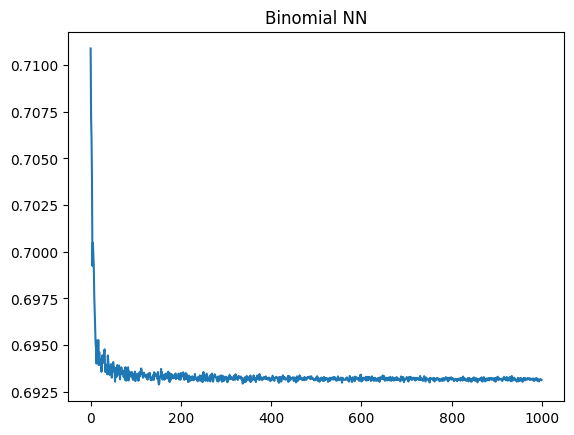

In [14]:
plt.plot(torch.arange(n_epochs), losses)
plt.title('Binomial NN'); 

In [15]:
n_epochs = 1000
model, losses = train(n_epochs = n_epochs, T = 3, spiker = 'gumbel', lr = 0.01)

Epoch [1000/1000], Step [100/125], Loss: 0.6500

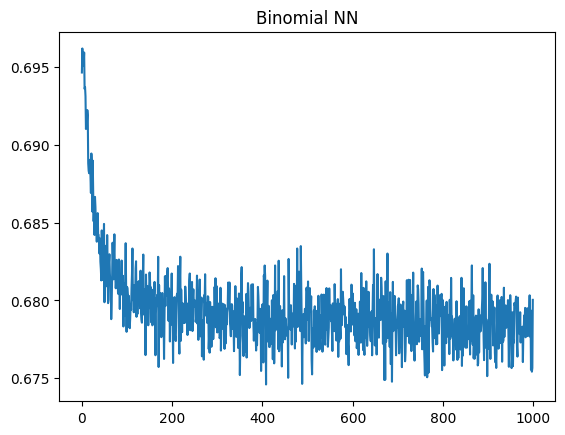

In [16]:
plt.plot(torch.arange(n_epochs), losses)
plt.title('Binomial NN'); 